In [1]:
import sys
sys.path.insert(1, '..')
from utils import *
from sklearn.metrics.pairwise import haversine_distances
from math import radians
from scipy.stats import gmean
import seaborn as sns
from pyswarms.single.global_best import GlobalBestPSO

%matplotlib inline

In [2]:
# https://gist.github.com/dsevero/3f3db7acb45d6cd8e945e8a32eaca168

from hashlib import sha256
from pandas.util import hash_pandas_object
from functools import lru_cache

class HashableDataFrame(pd.DataFrame):
    def __init__(self, obj):
        super().__init__(obj)

    def __hash__(self):
        hash_value = sha256(hash_pandas_object(self, index=True).values)
        hash_value = hash(hash_value.hexdigest())
        return hash_value

    def __eq__(self, other):
        return self.equals(other)


class HashableSeries(pd.Series):
    def __init__(self, obj):
        super().__init__(obj)

    def __hash__(self):
        hash_value = sha256(hash_pandas_object(self, index=True).values)
        hash_value = hash(hash_value.hexdigest())
        return hash_value

    def __eq__(self, other):
        return self.equals(other)
    
def make_hashable_pandas_object(obj):
    if type(obj) is pd.DataFrame:
        return HashableDataFrame(obj)
    elif type(obj) is pd.Series:
        return HashableSeries(obj)
    else:
        raise Exception(f'obj must be of type DataFrame or Series, '
                        f'but is {type(obj)}')

In [3]:
with open(join('..', '..', 'config.yml')) as f:
    config = yaml.safe_load(f)
    
pwd = config['pwd']
dpath = config['storage']
patterns = config['pattern-data-path'] 
util_datasets = config['util_datasets']
datasets = config['datasets']
colors = config['colors']
AREA_NAME = 'NYC'

FIG_SAVE_DIR = join(pwd, 'figures')
RESULT_SAVE_DIR = join(pwd, 'results')

HUFF_MODEL_SAVE_DIR = join(pwd, util_datasets, 'huff_model_params')
if not os.path.isdir(HUFF_MODEL_SAVE_DIR):
    os.mkdir(HUFF_MODEL_SAVE_DIR)

In [4]:
def get_cbg_locs(selected_cbgs=None):
    nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
    base_df = gpd.read_file(nyc_geojson)
    base_df = base_df.to_crs('EPSG:4326')
    base_df = base_df[base_df.BLKGRPCE != '0']
    
    if isinstance(selected_cbgs, str):
        base_df = base_df[base_df.GEOID.str[:5] == selected_cbgs]
    elif isinstance(selected_cbgs, set):
        base_df = base_df[base_df.GEOID.isin(selected_cbgs)]
        
    base_df['GEOID'] = base_df['GEOID'].astype(str).str[:-1]
    base_df = base_df.dissolve(by='GEOID', as_index=False)
    
    base_df['centroid_lon'] = base_df.geometry.centroid.x
    base_df['centroid_lat'] = base_df.geometry.centroid.y
    cbg_locs = base_df[['GEOID', 'centroid_lat', 'centroid_lon']].set_index('GEOID')
    
    return cbg_locs

In [5]:
def get_poi_areas(pois):
    poi_ids = pd.read_csv(join(pwd, util_datasets, 'safegraph_poi_areas.csv'), usecols=['safegraph_place_id', 'area_square_feet'], index_col='safegraph_place_id')
    return pois.join(poi_ids, how='inner')

def get_poi_attrs(poi_cat=None):
    poi_dir = join(pwd, dpath, 'area-pois', AREA_NAME)
    dfs = []
    for f in os.listdir(poi_dir):
        df = pd.read_csv(join(poi_dir, f))
        if poi_cat:
            df = df[df['top_category'] == poi_cat]
        dfs.append(df)

    df = pd.concat(dfs).drop_duplicates(subset=['safegraph_place_id'])

    poi_locs = df[['safegraph_place_id', 'latitude', 'longitude']].set_index('safegraph_place_id')
    res = get_poi_areas(poi_locs)
    return res[['latitude', 'longitude']], res[['area_square_feet']]

def get_cbg_poi_div_count():
    # return the poi count and diversity in the given cbgs
    shape_files = join(pwd, 'util_datasets', 'NY-msa-shapefiles')
    target_county_fips = set(pd.read_csv(join(pwd, 'util_datasets', 'NY-msa-counties.csv'))['fips'].astype(str))
    
    dfs = []
    for sh in os.listdir(shape_files):
        df = gpd.read_file(join(shape_files, sh))
        dfs.append(df[df['GEOID'].str[:5].isin(target_county_fips)][['GEOID', 'geometry']])
        
    tracts = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))
    
    tracts['GEOID'] = tracts['GEOID'].astype(str).str[:-1]
    tracts = tracts.dissolve(by='GEOID', as_index=False)
        
    poi_dir = join(pwd, dpath, 'area-pois', AREA_NAME)
    dfs = []
    for f in tqdm(os.listdir(poi_dir)):
        df = pd.read_csv(join(poi_dir, f), usecols=['safegraph_place_id', 'top_category', 'latitude', 'longitude'])
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
        dfs.append(gpd.sjoin(gdf, tracts, how='inner', op='within'))
        
    df = pd.concat(dfs).drop_duplicates(subset=['safegraph_place_id'])
    grouped = df.groupby('GEOID')
    diversity = grouped.apply(lambda x: len(x['top_category'].unique()))
    count = grouped.apply(lambda x: x['top_category'].shape[0])
    
    df = df.merge(diversity.rename('poi_diversity_where_store_is'), left_on='GEOID', right_index=True)
    res = df.merge(count.rename('poi_count_where_store_is'), left_on='GEOID', right_index=True)
    return res[['safegraph_place_id', 'poi_diversity_where_store_is', 'poi_count_where_store_is', 'GEOID']]

In [6]:
def match_poi2cbg(poi_locs):
    nyc_geojson = join(pwd, 'util_datasets', AREA_NAME, f'{AREA_NAME}-cbgs.json')
    base_df = gpd.read_file(nyc_geojson)
    base_df = base_df.to_crs('EPSG:4326')
    base_df = base_df[base_df.BLKGRPCE != '0']
    base_df = base_df[['GEOID', 'geometry']]
    
    gdf = gpd.GeoDataFrame(poi_locs.copy(), geometry=gpd.points_from_xy(poi_locs.longitude, poi_locs.latitude))
    
    return gpd.sjoin(gdf, base_df, how='inner', op='within')

In [7]:
def get_nvisits(row, cbg_visits, keys):
    poi = row['safegraph_place_id']
    entries = json.loads(row['visitor_home_cbgs'])
    for cbg in entries.keys():
        ct = cbg[:-1]
        if ct in keys:
            cbg_visits.loc[ct, poi] += entries[cbg]

In [8]:
def agg_visits_by_cbgs(distance_mat, pattern_files):
    cbg_visits = pd.DataFrame(np.zeros(distance_mat.shape), index=distance_mat.index, columns=distance_mat.columns)
    cbg_lookup = set(distance_mat.index)
    poi_lookup = set(distance_mat.columns)
    
    for f in tqdm(pattern_files):
        df = pd.read_csv(f)
        df = df[df.safegraph_place_id.isin(poi_lookup)]
        df.apply(get_nvisits, cbg_visits=cbg_visits, keys=cbg_lookup, axis=1)

    return cbg_visits

In [9]:
def get_spreader_cbgs(pct=0.75):
    spreader_cbgs = pd.read_csv(join(pwd, util_datasets, 'nyc_spreader_rank.csv'))
    return spreader_cbgs[spreader_cbgs['rank'] >= pct].cbg.astype(str).values

def gen_rand_loc(c_lat, c_lng, r=1000, rand_seed=0):
    # https://github.com/rmrs/random-location/blob/master/src/index.js
    sin_lat = np.sin(np.radians(c_lat))
    cos_lat = np.cos(np.radians(c_lat))
    
    np.random.seed(rand_seed)
    bearing = np.random.rand() * np.pi * 2
    sin_bearing = np.sin(bearing)
    cos_bearing = np.cos(bearing)
    
    t = r / 6371000
    sint = np.sin(t)
    cost = np.cos(t)
    
    rlat = np.arcsin(sin_lat * cost + cos_lat * sint * cos_bearing)
    rlng = np.radians(c_lng) + np.arctan2(sin_bearing * sint * cos_lat, cost - sin_lat * np.sin(rlat))
    rlng = ((rlng + np.pi*3) % (np.pi*2)) - np.pi;
    
    to_deg = lambda rad: rad / (np.pi / 180)
    
    return [to_deg(rlat), to_deg(rlng)]

In [10]:
def comp_dist_matrix(cbg_locs, poi_locs, betas=None):
    dist_matrix = pd.DataFrame(haversine_distances(np.radians(cbg_locs), np.radians(poi_locs)) * 6371, index=cbg_locs.index, columns=poi_locs.index)
    
    if isinstance(betas, set):
        for cbg, beta in betas.items():
            dist_matrix.loc[cbg] *= beta

    return dist_matrix

@lru_cache
def get_cbg_visits(dist_mat, start_date, end_date):
    pattern_dir = join(pwd, dpath, 'filtered-patterns-msa', 'NYC-patterns')
    date_format = '%Y-%m-%d'
    pattern_files = [(datetime.strptime(f.split('.')[0], date_format), join(pattern_dir, f)) for f in os.listdir(pattern_dir)]

    patterns = []
    for dt, f in pattern_files:
        if dt >= start_date and dt <= end_date:
            patterns.append(f)

    return agg_visits_by_cbgs(dist_mat, patterns)

In [11]:
def scale_range(values, new_min=1, new_max=10):
    old_min = np.min(values)
    old_max = np.max(values)
    
    old_range = (old_max - old_min)
    new_range = (new_max - new_min)
    return (((values - old_min) * new_range) / old_range) + new_min

def huff_corr(cbg_table, exp_distance, exp_area, get_corr=False):
    numerator = (cbg_table['area_square_feet']**exp_area)
    cbg_table['sim_nvisits'] = numerator / (cbg_table['distance']**exp_distance)
    
    if cbg_table['sim_nvisits'].sum() != 0:
        cbg_table['sim_nvisits'] /= cbg_table['sim_nvisits'].sum()

    cbg_table = cbg_table[~cbg_table['sim_nvisits'].isin([np.nan, np.inf, -np.inf])]
    
    corr_res = stats.pearsonr(cbg_table['nvisits'] / cbg_table['nvisits'].sum(), cbg_table['sim_nvisits'])
    
    if get_corr:
        return corr_res
    
    return 1 - corr_res[0]

def obj_func(X, cbg_table):
    n_particles = X.shape[0]
    cost = [huff_corr(cbg_table, *X[i]) for i in range(n_particles)]
    return np.array(cost)

def pso_huff_params(cbg_table, 
                    n_particles=20,
                    bounds=(np.array([1, 1]), np.array([100, 100])), 
                    options={'c1': 1.5, 'c2': 1.5, 'w': 0.9}, 
                    iters=20, 
                    n_processes=None, 
                    verbose=False):
    
    optimizer = GlobalBestPSO(n_particles=n_particles, 
                              dimensions=cbg_table.shape[1] - 1, 
                              options=options, 
                              bounds=bounds)
    
    cost, joint_vars = optimizer.optimize(obj_func, 
                                          iters=iters, 
                                          cbg_table=cbg_table, 
                                          verbose=verbose, 
                                          n_processes=n_processes)
    return cost, joint_vars

In [12]:
#boroughs = list(nyc_borough2fips.keys())
boroughs = ['Staten Island']
poi_cat = 'Grocery Stores'
# pause program begins
start_date = datetime(2020, 3, 22)
# phase 1 reopening
end_date = datetime(2020, 6, 8)

# poi locations and areas for the given category
poi_locs, poi_areas = get_poi_attrs(poi_cat=poi_cat)
# matching between pois and their home cbgs
poi_cbg_ids = match_poi2cbg(poi_locs)

In [13]:
# cbg device counts obtained from safegraph to be used as cbg populations
device_count = pd.read_csv(join(pwd, util_datasets, 'ny-msa-device-counts.csv'))
# discard time zones
device_count.date_range_start = device_count.date_range_start.apply(lambda x: x.split('T')[0])
device_count.date_range_start = pd.to_datetime(device_count.date_range_start, errors='raise')
# filter wrt start and end dates
device_count = device_count[(device_count.date_range_start >= start_date) & (device_count.date_range_start <= end_date)]
# get census tracts
device_count['census_tract'] = device_count.census_block_group // 10

2022-09-19 23:44:31,101 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-09-19 23:44:31,104 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


100%|████████████████████████████████████████████████████████████████████████████████| 109/109 [56:56<00:00, 31.35s/it]


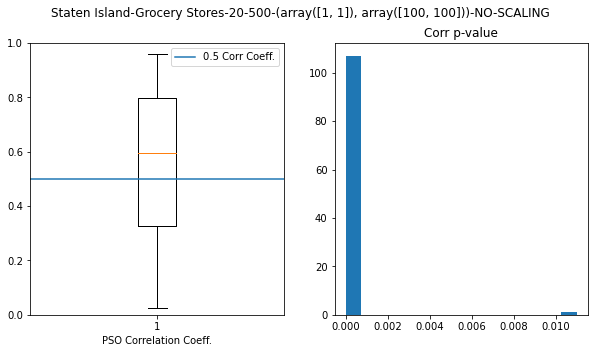

In [14]:
# simulation settings
n_particles=20
iters=500
n_processes=None
bounds_list=[(np.array([1, 1]), np.array([5, 5])), 
             (np.array([1, 1]), np.array([10, 10])), 
             (np.array([1, 1]), np.array([50, 50])), 
             (np.array([1, 1]), np.array([100, 100]))]

for bounds in bounds_list:
    for borough in boroughs:            
        experiment_file = f'{borough}-{poi_cat}-{n_particles}-{iters}-{str(bounds)}-NO-SCALING'
        
        if os.path.exists(join(HUFF_MODEL_SAVE_DIR, experiment_file + '.csv')):
            continue

        selected_cbgs = str(nyc_borough2fips[borough])
        # get source borough cbgs
        cbg_locs = get_cbg_locs(selected_cbgs=selected_cbgs)
        # calculate the distance matrix
        dist_mat = comp_dist_matrix(cbg_locs, poi_locs)
        # make it hashable
        dist_mat = make_hashable_pandas_object(dist_mat)
        # aggregate visits from cbgs to pois
        poi_cbg_visits = get_cbg_visits(dist_mat, start_date, end_date)

        # a list to store cbg pso results
        cbg_exps = []
        for cbg in tqdm(dist_mat.index):
            visits = poi_cbg_visits.loc[cbg].rename('nvisits')

            # discard cbgs with no visit observations
            if visits.sum() == 0:
                continue

            dist = dist_mat.loc[cbg].rename('distance')

            table = pd.concat([visits, dist, poi_areas], axis=1, join='inner')
            features = table.columns.tolist()
            features.remove('nvisits')

#             for f in features:
#                 table[f] = scale_range(table[f].values)

            params = pso_huff_params(table, 
                                     n_particles=n_particles, 
                                     iters=iters, 
                                     n_processes=n_processes, 
                                     bounds=bounds)

            corr = huff_corr(table, *params[1], get_corr=True)

            cbg_exps.append({'census_tract': cbg,
                             'exp_distance': params[1][0],
                             'exp_area': params[1][1],
                             'corr': corr[0], 
                             'p': corr[1]})

        res = pd.DataFrame(cbg_exps)
        res.to_csv(join(HUFF_MODEL_SAVE_DIR, experiment_file + '.csv'), index=False)

        # plot model performance
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        cax = axes[0]
        cax.boxplot(res['corr'])
        cax.set_ylim([0, 1])
        cax.axhline(0.5, label='0.5 Corr Coeff.')
        cax.set_xlabel('PSO Correlation Coeff.')
        cax.legend()

        pax = axes[1]
        pax.hist(res['p'], bins='scott')
        pax.set_title('Corr p-value')

        fig.suptitle(experiment_file)
    
        fig.savefig(join(HUFF_MODEL_SAVE_DIR, experiment_file + '.png'), bbox_inches='tight')

In [29]:
# fig, axes = plt.subplots(2, 3, figsize=(20, 10))
# cols = ['exp_distance', 'exp_area', 'exp_poi_diversity', 'exp_poi_count', 'corr', 'p']
# col2name = dict(zip(cols, ['Distance', 'Area', 'POI Diversity Where Store is', 'POI Count Where Store is', 'Spearman Corr', 'P value']))

# for ax, col in zip(axes.flatten(), cols):
#     sns.boxplot(x='borough', y=col, data=res, ax=ax)
#     ax.set_title(col2name[col], fontsize=13)
#     ax.set_xlabel(None)
#     ax.set_ylabel(None)
    
# fig.suptitle('Resulting Huff Exponents For Each Borough (Model Evaluation wtih Spearman Corr and P values)', fontsize=20, y=.96)
# fig.savefig(join(FIG_SAVE_DIR, 'huff-model-exps-detailed.png'), bbox_inches='tight')

In [14]:
# calculate poi per capita
# borough populations: https://data.cityofnewyork.us/City-Government/New-York-City-Population-by-Borough-1950-2040/xywu-7bv9
borough_population = {'Bronx': 1446788, 'Brooklyn': 2648452, 'Manhattan': 1638281, 'Queens': 2330295, 'Staten Island': 487155}
poi_cbg_ids['borough'] = poi_cbg_ids.GEOID.str[:5].apply(lambda x: nyc_fips2borough[int(x)])
poi_counts_by_borough = poi_cbg_ids.groupby('borough').size()
poi_per_capita_by_borough = poi_counts_by_borough / pd.Series(borough_population)
# per 1K residents
poi_per_capita_by_borough * 10**3

borough
Bronx            0.435447
Brooklyn         0.470086
Manhattan        0.582928
Queens           0.414111
Staten Island    0.332543
dtype: float64

In [16]:
# median distance traveled
def median_dist_by_borough(dist_mat, cbg_visits):
    d = []
    for cbg in dist_mat.index:
        visits = cbg_visits.loc[cbg]
        visits = visits[visits > 0]
        dist = dist_mat.loc[cbg, visits.index]
        visit_w_dists = dist.repeat(np.ceil(visits).astype(int).values)
        d.extend(visit_w_dists)
    return np.nanmedian(d)

for borough, fips in nyc_borough2fips.items():
    selected_cbgs = str(nyc_borough2fips[borough])
    sel_cbg_locs = get_cbg_locs(selected_cbgs=selected_cbgs)
    
    d_mat = comp_dist_matrix(sel_cbg_locs, poi_locs)
    d_mat = make_hashable_pandas_object(d_mat)
    poi_cbg_visits = get_cbg_visits(d_mat, start_date, end_date)
    
    print(borough, 'Median Distance Traveled (in km): ', '%.2f' % median_dist_by_borough(d_mat, poi_cbg_visits))

Staten Island Median Distance Traveled (in km):  2.66


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:08<00:00,  1.36it/s]


Manhattan Median Distance Traveled (in km):  0.90


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:12<00:00,  1.05s/it]


Bronx Median Distance Traveled (in km):  1.26


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.30s/it]


Queens Median Distance Traveled (in km):  1.71


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:15<00:00,  1.32s/it]


Brooklyn Median Distance Traveled (in km):  1.35


In [127]:
def simulate_matching_poi_per_capita(source_borough, 
                                     target_borough,
                                     model_param_file,
                                     ct_populations,
                                     poi_cat, 
                                     poi_per_capita_by_borough, 
                                     borough_population, 
                                     poi_counts_by_borough, 
                                     poi_locs, 
                                     poi_areas, 
                                     area_expansion,
                                     start_date, 
                                     end_date, 
                                     pois_in_spreader_cbgs, 
                                     non_source_borough_poi, 
                                     r=1000, 
                                     rand_seed=0,
                                     verbose=True):
    # given a pair of source and target boroughs, adjust the # of pois in source borough 
    # so that the poi per capita will be the same as target borough
    if isinstance(target_borough, str):
        new_num_pois = poi_per_capita_by_borough[target_borough] * borough_population[source_borough]
    else: # it's directly a poi density
        new_num_pois = target_borough * borough_population[source_borough]
    num_pois = poi_counts_by_borough[source_borough]
    ndiff = int(new_num_pois - num_pois)
    
    if ndiff < 0:
        print('can not add hypothetical POIs to the given source borough')
    else:
        params_df = pd.read_csv(model_param_file)
        params_df.cbg = params_df.census_tract.astype(str)
        params_df = params_df.set_index('census_tract')
            
        selected_cbgs = str(nyc_borough2fips[source_borough])
        cbg_locs = get_cbg_locs(selected_cbgs=selected_cbgs)
        
        poi_locs = poi_locs.drop('sg:1324350d09df44c7a1df7e3e1b984850')
        poi_areas = poi_areas.drop('sg:1324350d09df44c7a1df7e3e1b984850')
        
        rand_gen_poi_locs = []
        np.random.seed(rand_seed)
        for cbg in np.random.choice(cbg_locs.index, size=ndiff, replace=True):
            entry = cbg_locs.loc[cbg]
            rand_gen_poi_locs.append(gen_rand_loc(entry['centroid_lat'], entry['centroid_lon'], r, rand_seed=rand_seed))

        rand_gen_poi_locs = pd.DataFrame(rand_gen_poi_locs, columns=poi_locs.columns)
        sim_poi_locs = pd.concat([poi_locs, rand_gen_poi_locs])
        
        # get mean poi area in source borough
        mean_poi_area = poi_areas.loc[poi_cbg_ids[poi_cbg_ids.borough == source_borough].index].area_square_feet.mean()
        sim_poi_areas = pd.concat([poi_areas.area_square_feet, 
                                   pd.Series(mean_poi_area * (1+area_expansion)) \
                                       .repeat(len(rand_gen_poi_locs)) \
                                       .reset_index(drop=True) \
                                       .rename('safegraph_place_id')
                                  ])
        
        def comp_huff_mat(poi_locs, areas):
            dist_mat = comp_dist_matrix(cbg_locs, poi_locs)
            for cbg in dist_mat.index:
                exp_dist = params_df.loc[cbg, 'exp_distance'] if cbg in params_df.index else params_df['exp_distance'].mean()
                dist_mat.loc[cbg] = dist_mat.loc[cbg] ** -exp_dist
                
                exp_area = areas.loc[dist_mat.columns] ** (params_df.loc[cbg, 'exp_area'] if cbg in params_df.index else params_df['exp_area'].mean())
                dist_mat.loc[cbg] = dist_mat.loc[cbg] * exp_area
                
                dist_mat.loc[cbg] /= dist_mat.loc[cbg].sum()
                
            return dist_mat
            
        sim_huff_mat = comp_huff_mat(sim_poi_locs, sim_poi_areas)
        
        area_series = poi_areas.area_square_feet
        act_huff_mat = comp_huff_mat(poi_locs, area_series)
        act_huff_mat = make_hashable_pandas_object(act_huff_mat)

        poi_cbg_visits = get_cbg_visits(act_huff_mat, start_date, end_date)
        visits = poi_cbg_visits.sum(axis=1)
        
        sim_visits = sim_huff_mat.mul(visits, axis=0).sum(axis=0)
        
        dist_matrix = comp_dist_matrix(cbg_locs, poi_locs)
        def population_weighted_distance(visits, population):
            dists = []
            for cbg in dist_matrix.index:
                visits = poi_cbg_visits.loc[cbg]
                visits = visits[visits > 0]
                d = dist_matrix.loc[cbg, visits.index]
                dists.extend(list(np.repeat(d, population.loc[cbg])))
            return np.nanmedian(dists)
        
        # aggregate all the visits from CBGs for POIs
        act_visits = poi_cbg_visits.loc[:, (poi_cbg_visits != 0).any(axis=0)].sum(axis=0)
        # and get the pct diff for each POI
        diff = (sim_visits.loc[act_visits.index] - act_visits) / act_visits
        
        if verbose:
            print('expansion_factor:', area_expansion)
            # change in median distance
            sim_median_dist = population_weighted_distance(sim_visits, ct_populations)
            act_median_dist = population_weighted_distance(act_visits, ct_populations)
            print('Change in population weighted median distance in km', (sim_median_dist - act_median_dist)/ act_median_dist)
        
        # now filter the diffs wrt their CBG locations (hotspot etc.)
        # and aggregate the diffs
        change_res = diff[diff.index.isin(pois_in_spreader_cbgs)].mean()
        if verbose:
            print(f'Change in visits for spreader CBGs {change_res}')
        
            # change in visits to none-home borough CBGs
            print(f'Change in visits to non-{source_borough} CBGs: {diff[diff.index.isin(non_source_borough_poi)].mean()}')
            print()
        
        return change_res, ndiff

In [15]:
# find the experiment setting with the highest median correlation coeff
corr_lst = []
for f in os.listdir(HUFF_MODEL_SAVE_DIR):
    if f.endswith('csv'):
        corr_lst.append([f, pd.read_csv(join(HUFF_MODEL_SAVE_DIR, f))['corr'].median()])

model_params = max(corr_lst, key=lambda x: x[1])[0]

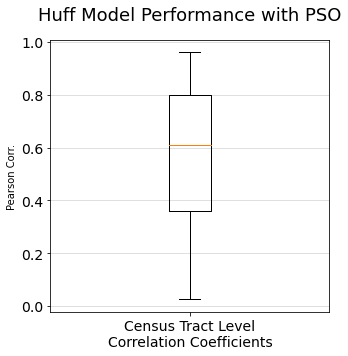

In [16]:
df = pd.read_csv(join(HUFF_MODEL_SAVE_DIR, model_params))

fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(df['corr'])
ax.set_xticklabels(['Census Tract Level\nCorrelation Coefficients'], fontsize=14)
ax.tick_params(labelsize=14)
#ax.axhline(0.5, c='r', linestyle='--', linewidth=1, label='0.5 ')
ax.grid(axis='y', alpha=0.5)
ax.set_title('Huff Model Performance with PSO', fontsize=18, y=1.05)
ax.set_ylabel('Pearson Corr.')

fig.savefig(join(FIG_SAVE_DIR, 'huff-performance.pdf'), bbox_inches='tight')
fig.savefig(join(FIG_SAVE_DIR, 'huff-performance.png'), bbox_inches='tight')

In [78]:
source_borough = 'Staten Island'
target_boroughs = ['Manhattan', 'Queens']
poi_cat = 'Grocery Stores'

rand_loc_seed = 0
# get borough population
ct = device_count[device_count['census_tract'].astype(str).str[:5] == str(nyc_borough2fips[source_borough])]
# find the max device count within the time range
ct_pops = ct.groupby('census_tract').number_devices_residing.max()
ct_pops.index = ct_pops.index.astype(str)

model_param_file = join(HUFF_MODEL_SAVE_DIR,  model_params)

# area expansion factor for hypothetical pois
area_expansion_lst = np.linspace(0, 1, 20)

# spreader cbgs ordered by occurrence rank
spreader_cbgs = set(get_spreader_cbgs(pct=0.75))
# find the pois in those cbgs
pois_in_spreader_cbgs = poi_cbg_ids[poi_cbg_ids.GEOID.isin(spreader_cbgs)].index 
# cbgs located in other boroughs
non_source_borough_poi = poi_cbg_ids[poi_cbg_ids.borough != source_borough].index

change_df = {}
for target_borough in target_boroughs:
    change_in_spreader_visits = []
    for area_expansion in area_expansion_lst:
        chg, diff = simulate_matching_poi_per_capita(source_borough, target_borough, model_param_file, ct_pops, poi_cat, poi_per_capita_by_borough, 
                                               borough_population, poi_counts_by_borough, poi_locs, poi_areas, area_expansion,
                                               start_date, end_date, pois_in_spreader_cbgs, non_source_borough_poi, r=1000, rand_seed=rand_loc_seed)
        change_in_spreader_visits.append(chg)
    change_df[target_borough] = {'values': change_in_spreader_visits, 'diff': diff}

expansion_factor: 0.0
Change in population weighted median distance in km 0.0
Change in visits for spreader CBGs -0.47382725789038926
Change in visits to non-Staten Island CBGs: -0.999999824618609

expansion_factor: 0.05263157894736842
Change in population weighted median distance in km 0.0
Change in visits for spreader CBGs -0.4817168098820819
Change in visits to non-Staten Island CBGs: -0.9999998451170434

expansion_factor: 0.10526315789473684
Change in population weighted median distance in km 0.0
Change in visits for spreader CBGs -0.489215639100359
Change in visits to non-Staten Island CBGs: -0.9999998629419679

expansion_factor: 0.15789473684210525
Change in population weighted median distance in km 0.0
Change in visits for spreader CBGs -0.4963427010571941
Change in visits to non-Staten Island CBGs: -0.9999998784258027

expansion_factor: 0.21052631578947367
Change in population weighted median distance in km 0.0
Change in visits for spreader CBGs -0.5031195732653423
Change in vi

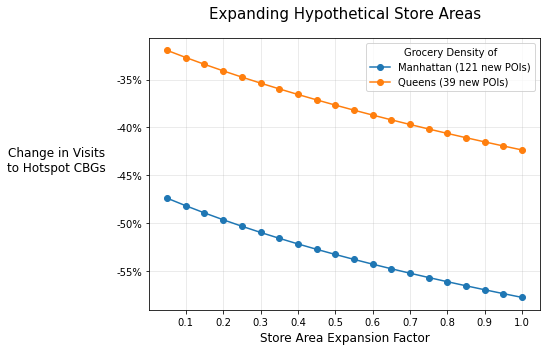

In [82]:
fig, ax = plt.subplots(figsize=(7, 5))

for borough, entry in change_df.items():
    ax.plot(area_expansion_lst, entry['values'], marker='o', label=f'{borough} ({entry["diff"]} new POIs)')
ax.set_ylabel('Change in Visits\nto Hotspot CBGs', fontsize=12, rotation=0, labelpad=60)
ax.set_xticks(area_expansion_lst[1::2])
ax.set_xticklabels([f'{t:.1f}' for t in area_expansion_lst[1::2]])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))
ax.set_xlabel('Store Area Expansion Factor', fontsize=12)
ax.grid(alpha=0.3)
ax.set_title(f'Expanding Hypothetical Store Areas', fontsize=15, y=1.05)
ax.legend(title='Grocery Density of')

fig.savefig(join(FIG_SAVE_DIR, f'diff-store-area.pdf'), bbox_inches='tight')

In [148]:
source_borough = 'Staten Island'
base_poi_den = poi_per_capita_by_borough[source_borough]
poi_densities = np.linspace(base_poi_den, base_poi_den*2, 20)

area_expansion = 0
n_iter = 30

sample_vals = []
for poi_density in tqdm(poi_densities):
    change_in_visits = []
    for it in range(n_iter):
        rand_loc_seed = np.random.randint(0, 1000)
        chg, diff = simulate_matching_poi_per_capita(source_borough, poi_density, model_param_file, ct_pops, poi_cat, poi_per_capita_by_borough, 
                                                   borough_population, poi_counts_by_borough, poi_locs, poi_areas, area_expansion,
                                                   start_date, end_date, pois_in_spreader_cbgs, non_source_borough_poi, r=1000, rand_seed=rand_loc_seed, verbose=False)
        change_in_visits.append(chg)
    sample_vals.append(change_in_visits)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [30:40<00:00, 92.02s/it]


In [149]:
mean_vals = []
low = []
high = []
for values in sample_vals:
    mean_vals.append(np.mean(values))
    l, h = bootstrap_ci(values, stat=np.mean, ci_level=95, repetition=10**3)
    low.append(l)
    high.append(h)

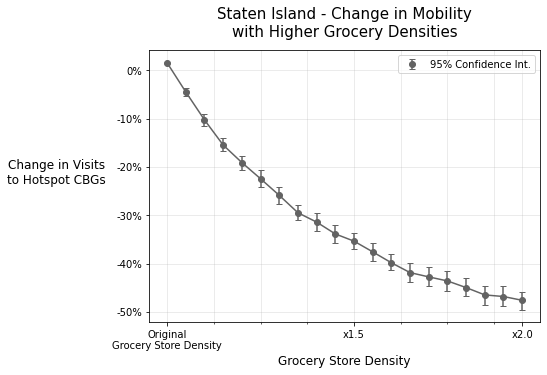

In [177]:
from matplotlib.ticker import AutoMinorLocator

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(poi_densities, mean_vals, c='#636363')
ax.errorbar(poi_densities, mean_vals, [mean_vals - np.array(low), np.array(high) - mean_vals], 
            fmt='o', label='95% Confidence Int.', capsize=3, color='#636363', markerfacecolor='#636363', markeredgecolor='#636363')
ax.set_ylabel('Change in Visits\nto Hotspot CBGs', fontsize=12, rotation=0, labelpad=60)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y*100:.0f}%'))

ticks = np.array(poi_densities)[[0, 10, -1]]
ax.set_xticks(ticks)
ax.set_xticklabels([f'x{t/ticks[0]:.1f}' if ind != 0 else f'Original\nGrocery Store Density' for ind, t in enumerate(ticks)])
ax.set_xlabel('Grocery Store Density', fontsize=12)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.set_title('Staten Island - Change in Mobility\nwith Higher Grocery Densities', fontsize=15, y=1.03)
ax.grid(alpha=0.3, which='both')
ax.legend()

fig.savefig(join(FIG_SAVE_DIR, 'poi-density.pdf'), bbox_inches='tight')